# Superresolution example based on transpose convolutional network
Ref - https://towardsdatascience.com/transposed-convolutional-neural-networks-how-to-increase-the-resolution-of-your-image-d1ec27700c6a

## Import libraries

In [6]:
# Tensorflow / Keras
import tensorflow as tf # for building Neural Networks

from tensorflow import keras # for building Neural Networks
from keras.models import Model # for assembling a Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Conv2D, Conv2DTranspose # for adding layers to our Neural Network

In [5]:
# Data manipulation
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

# Sklearn
import sklearn # for model evaluation
from sklearn.model_selection import train_test_split # for splitting the data into train and test samples

# Visualization
import cv2              # for ingesting images
import matplotlib.pyplot as plt  # for showing images

# Other utilities
import sys
import os

In [4]:
# print version
print('Tensorflow/Keras: %s' % keras.__version__)
print('pandas: %s' % pd.__version__)
print('numpy: %s' % np.__version__)
print('sklearn: %s' % sklearn.__version__)
print('OpenCV: %s' % cv2.__version__) # print version

Tensorflow/Keras: 2.8.0
pandas: 1.3.5
numpy: 1.21.6
sklearn: 1.0.2
OpenCV: 4.1.2


## Load & Process Data

In [7]:
DATA_DIR = 'dog'
LOW_RES = (64, 64)
HIGH_RES = (256, 256)

In [8]:
# Load images and resize (Image pair of 64x64 and 256x256)
data_lowres = []
data_hires = []
for img_fname in os.listdir(DATA_DIR):
    image = cv2.imread(os.path.join(DATA_DIR, img_fname))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    data_lowres.append(cv2.resize(image, LOW_RES))
    data_hires.append(cv2.resize(image, HIGH_RES))
    
# Convert image data to numpy array and standardize values
data_lowres = np.array(data_lowres, dtype="float") / 255.0
data_hires = np.array(data_hires, dtype="float") / 255.0

# Show data shape
print("Shape of whole data_lowres: ", data_lowres.shape)
print("Shape of whole data_hires: ", data_hires.shape)


Shape of whole data_lowres:  (172, 64, 64, 3)
Shape of whole data_hires:  (172, 256, 256, 3)


In [9]:
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(data_lowres, data_hires, test_size=0.2, random_state=0)

# Print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", Y_test.shape)

Shape of X_train:  (137, 64, 64, 3)
Shape of Y_train:  (137, 256, 256, 3)
Shape of X_test:  (35, 64, 64, 3)
Shape of Y_test:  (35, 256, 256, 3)


## Data Visualization

#### Low resolution (64 x 64 pixels)

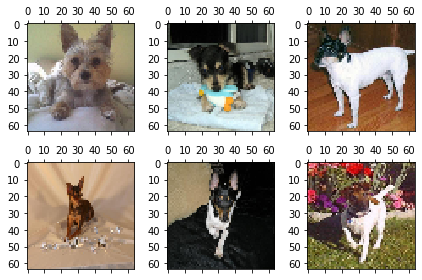

In [13]:
# Display images of 6 pandas in the training set (low resolution 64 x 64 pixels)
fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(6, 4))
n=0
for i in range(2):
    for j in range(3):
        axs[i,j].matshow(X_train[n])
        n=n+1

### Higher resolution (256 x 256 pixels)

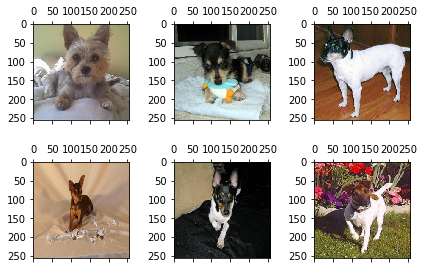

In [14]:
# Display images of 6 pandas in the test set (higher resolution 256 x 256 pixels)
fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(6, 4))
n=0
for i in range(2):
    for j in range(3):
        axs[i,j].matshow(Y_train[n])
        n=n+1

## Train Model (Transposed Convolution)

In [21]:
EPOCH = 50
BATCH_SIZE = 4

In [15]:
# Input Layer
input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]) # Specify input shape
inputs = Input(shape=input_shape, name='Input-Layer')

In [16]:
# Upsampling from 64x64 to 256x256 using Transposed Convolutions
d = Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2,2), activation="relu", padding="same", name='Transpose-Conv2D-Layer-1')(inputs)
d = Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2,2), activation="relu", padding="same", name='Transpose-Conv2D-Layer-2')(d)

In [17]:
# Added Convolutional layer to bring the number of filters down to 3
outputs = Conv2D(filters=3, kernel_size=(3, 3), activation="sigmoid", padding="same", name='Output-Layer')(d)

In [19]:
# Compile model
model = Model(inputs, outputs, name='Transposed-Convolutional-NN')
model.compile(optimizer="adam", loss="mse", metrics=["mse"])
model.summary()

Model: "Transposed-Convolutional-NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 Transpose-Conv2D-Layer-1 (C  (None, 128, 128, 64)     832       
 onv2DTranspose)                                                 
                                                                 
 Transpose-Conv2D-Layer-2 (C  (None, 256, 256, 128)    32896     
 onv2DTranspose)                                                 
                                                                 
 Output-Layer (Conv2D)       (None, 256, 256, 3)       3459      
                                                                 
Total params: 37,187
Trainable params: 37,187
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train Transpose Convolutional model
model.fit(X_train, Y_train, epochs=EPOCH, batch_size=BATCH_SIZE, verbose=1, validation_data=(X_test, Y_test))

## Evaluation

In [23]:
TEST_IDX = 0

In [24]:
# Take test image
test_image = X_test[TEST_IDX]
test_image = test_image[np.newaxis, ...]

# Inference
test_img_upscale = model.predict(test_image)[0]

[Text(0.5, 1.05, 'Original Hi-Res')]

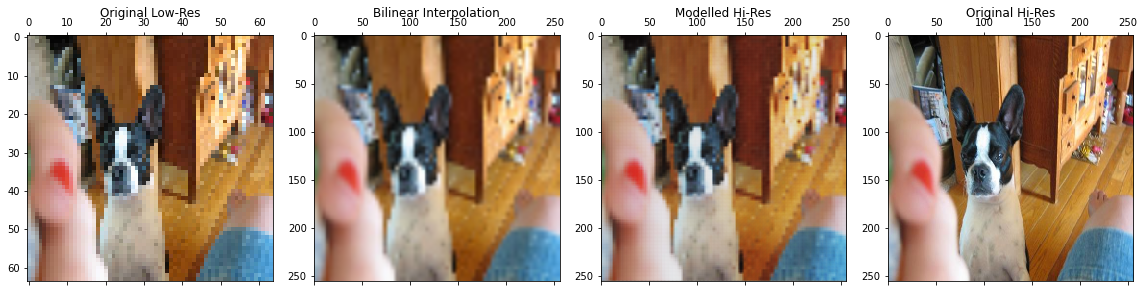

In [30]:
# Display image comparisons for test example
fig, axs = plt.subplots(1, 4, tight_layout=True, figsize=(16, 9), facecolor='white')

axs[0].matshow(X_test[TEST_IDX])
axs[0].set(title='Original Low-Res')
axs[1].matshow(cv2.resize(X_test[TEST_IDX], HIGH_RES, interpolation=cv2.INTER_LINEAR))
axs[1].set(title='Bilinear Interpolation')
axs[2].matshow(test_img_upscale)
axs[2].set(title='Modelled Hi-Res')
axs[3].matshow(Y_test[TEST_IDX])
axs[3].set(title='Original Hi-Res')